## Trying out the wave methods in Simon & Radek's TEMPO paper

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from scipy.signal import correlate, correlation_lags

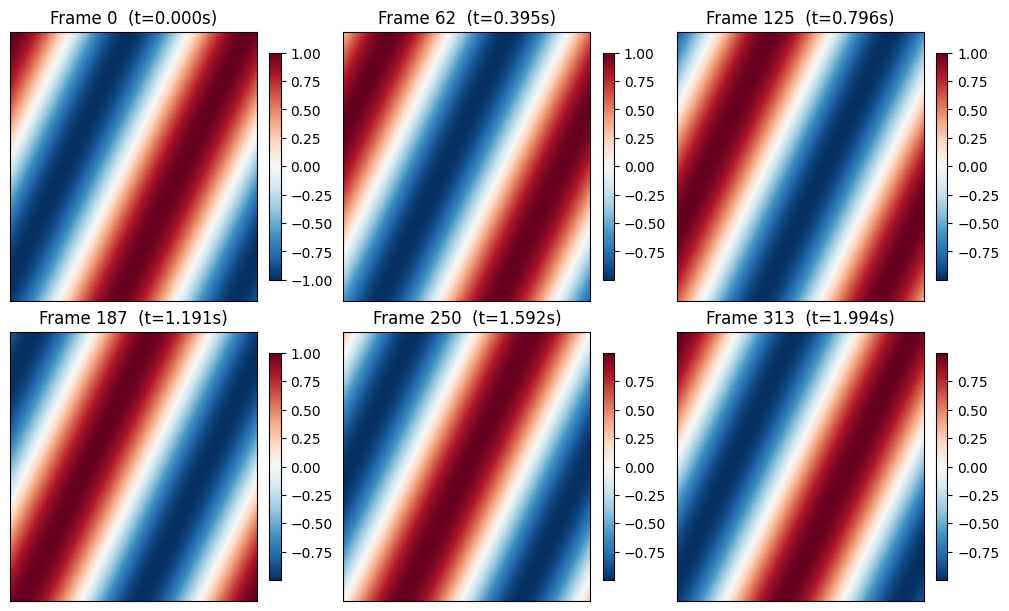

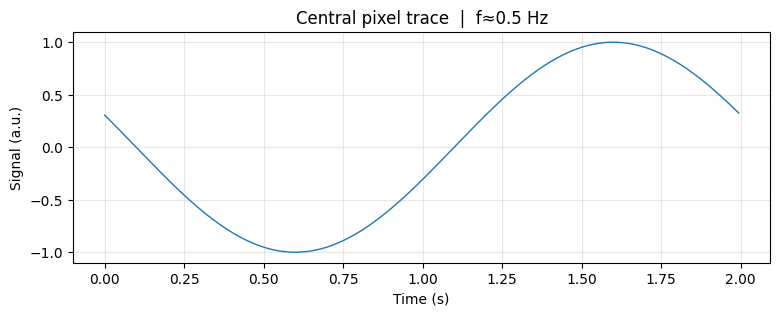

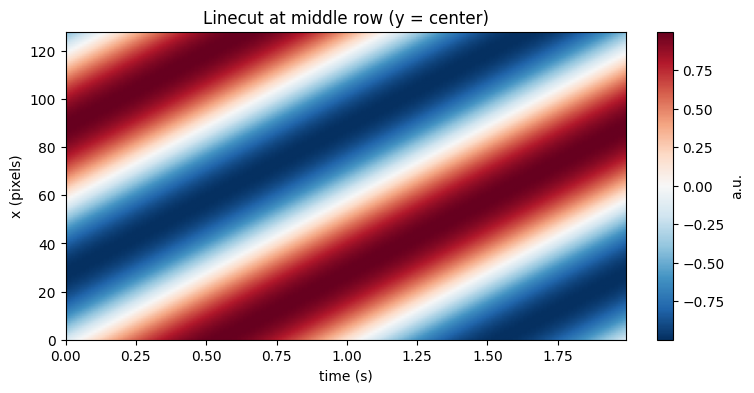

Meta: {'ny': 96, 'nx': 128, 'nt': 314, 'fps': 157.0, 'freq_hz': 0.5, 'speed_mm_s': 5.0, 'direction_deg': 35.0, 'px_size_mm': 0.1, 'ux': np.float64(0.8191520442889918), 'uy': np.float64(0.573576436351046)}


In [20]:
# --- Movie generator: planar travelling wave + gaussian noise ---
def make_planar_wave(
    ny: int = 96,
    nx: int = 128,
    duration_s: float = 2.0,
    fps: float = 157.0,
    freq_hz: float = 0.5,
    speed_mm_s: float = 5.0,
    direction_deg: float = 35.0,   # propagation direction (0° = +x, 90° = +y)
    px_size_mm: float = 0.1,       # pixel size (each pixel spans this many mm)
    amplitude: float = 1.0,
    noise_std: float = 0.15,
    seed: int | None = 0,
) -> tuple[NDArray, NDArray, dict]:
    """
    Create a planar travelling-wave movie V(y,x,t).

    Returns
    -------
    movie : (ny, nx, nt) float32
    t     : (nt,) time vector in seconds
    meta  : dict with parameters and derived quantities
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    nt = int(round(duration_s * fps))
    t = np.arange(nt) / fps

    # Spatial grid in *millimeters*
    y = np.arange(ny) * px_size_mm
    x = np.arange(nx) * px_size_mm
    Y, X = np.meshgrid(y, x, indexing='ij')  # (ny, nx)

    # Unit direction vector u_hat
    theta = np.deg2rad(direction_deg)
    ux, uy = np.cos(theta), np.sin(theta)

    # Phase argument: 2π f [t - (u·r)/c]
    # where r = (X, Y), u·r = ux*X + uy*Y  [mm], c = speed_mm_s [mm/s]
    # So delay field τ(x,y) = (ux*X + uy*Y)/c  [s]
    c = speed_mm_s
    delay = (ux * X + uy * Y) / c  # seconds

    # Broadcast to time: t[None,None,:] - delay[:,:,None]
    phase = 2 * np.pi * freq_hz * (t[None, None, :] - delay[:, :, None])
    clean = amplitude * np.cos(phase)

    # Additive Gaussian noise
    noise = noise_std * rng.standard_normal(size=clean.shape)
    movie = (clean + noise).astype(np.float32)

    meta = dict(
        ny=ny, nx=nx, nt=nt, fps=fps, freq_hz=freq_hz, speed_mm_s=speed_mm_s,
        direction_deg=direction_deg, px_size_mm=px_size_mm,
        ux=ux, uy=uy
    )
    return movie, t, meta

# --- Make a movie and do quick checks ---
movie, t, meta = make_planar_wave(noise_std=0)

ny, nx, nt = movie.shape
fps = meta["fps"]

# Choose a few frames to inspect
frames_to_show = np.linspace(0, nt-1, 6, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)
for ax, fr in zip(axes.ravel(), frames_to_show):
    im = ax.imshow(movie[:, :, fr], cmap='RdBu_r', origin='upper', aspect='auto')
    ax.set_title(f"Frame {fr}  (t={t[fr]:.3f}s)")
    ax.set_xticks([]); ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046)
plt.show()

# Plot the time trace at a central pixel to verify frequency and SNR
cy, cx = ny // 2, nx // 2
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(t, movie[cy, cx, :], lw=1)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal (a.u.)")
ax.set_title(f"Central pixel trace  |  f≈{meta['freq_hz']} Hz")
ax.grid(True, alpha=0.3)
plt.show()

# Optional: a quick space–time line cut along the propagation direction
# We'll slice along a line at the central y and plot x vs time.
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(
    movie[cy, :, :],  # (x, t)
    origin='lower', aspect='auto',
    extent=[t[0], t[-1], 0, nx],
    cmap='RdBu_r'
)
ax.set_ylabel("x (pixels)")
ax.set_xlabel("time (s)")
ax.set_title("Linecut at middle row (y = center)")
plt.colorbar(im, ax=ax, fraction=0.046, label='a.u.')
plt.show()

print("Meta:", meta)

Meta: {'ny': 96, 'nx': 128, 'nt': 314, 'fps': 157.0, 'freq_hz': 10.0, 'speed_mm_s': 250.0, 'direction_deg': 35.0, 'px_size_mm': 0.1, 'ux': np.float64(0.8191520442889918), 'uy': np.float64(0.573576436351046)}


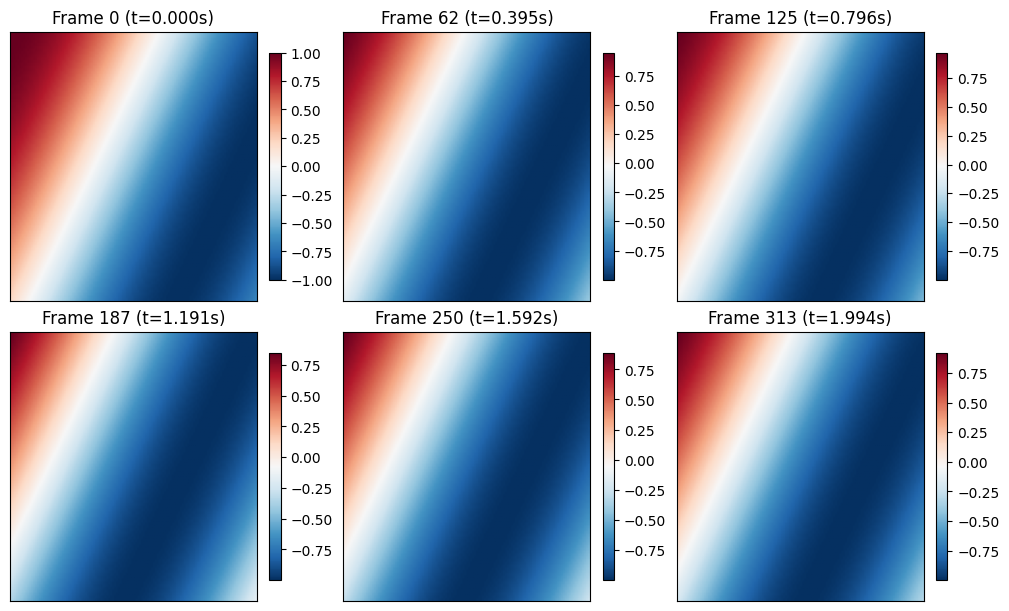

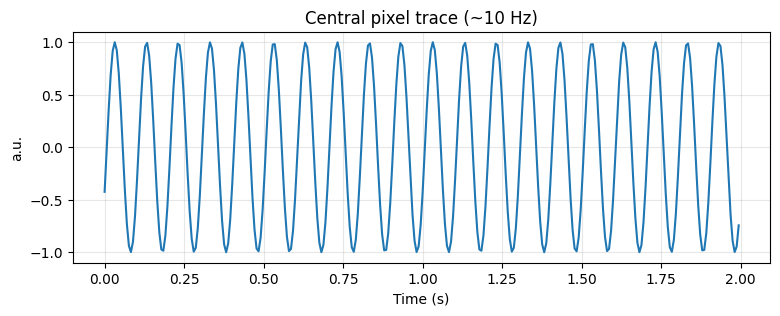

In [29]:
# --- New mock: safe for correlation-based delay mapping ---
movie, t, meta = make_planar_wave(
    ny=96, nx=128,
    duration_s=2.0,
    fps=157.0,
    freq_hz=10.0,        # 10 Hz ⇒ T=0.1 s
    speed_mm_s=250.0,    # fast enough that delays < T/2 across FOV
    direction_deg=35.0,
    px_size_mm=0.1,
    amplitude=1.0,
    noise_std=0.0,
    seed=1
)

print("Meta:", meta)

# Quick sanity plots (optional): frames + central pixel trace
frames_to_show = np.linspace(0, meta['nt']-1, 6, dtype=int)
fig, axes = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)
for ax, fr in zip(axes.ravel(), frames_to_show):
    im = ax.imshow(movie[:, :, fr], cmap='RdBu_r', origin='upper', aspect='auto')
    ax.set_title(f"Frame {fr} (t={t[fr]:.3f}s)")
    ax.set_xticks([]); ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046)
plt.show()

cy, cx = movie.shape[0]//2, movie.shape[1]//2
plt.figure(figsize=(9,3))
plt.plot(t, movie[cy, cx, :]); plt.grid(True, alpha=0.3)
plt.xlabel("Time (s)"); plt.ylabel("a.u.")
plt.title("Central pixel trace (~10 Hz)"); plt.show()

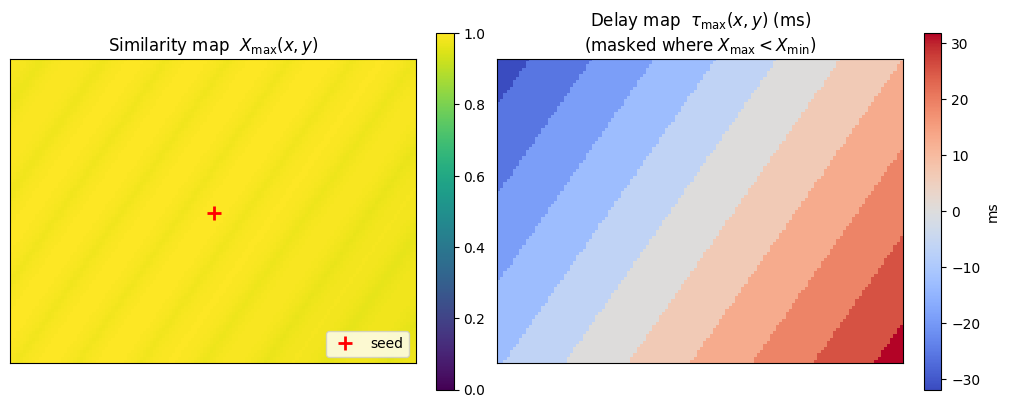

Kept 12288 / 12288 pixels after Xmin=0.7


In [36]:

def compute_delay_map(
    movie,
    seed_yx=None,
    fps: float = 157.0,
    max_lag_s: float = 0.04,   # keep < T/2
    Xmin: float = 0.7
):
    ny, nx, nt = movie.shape
    if seed_yx is None:
        seed_yx = (ny // 2, nx // 2)

    sy, sx = seed_yx
    seed = movie[sy, sx, :]
    seed = (seed - seed.mean()) / (seed.std() + 1e-12)

    max_lag = int(round(max_lag_s * fps))
    lags = correlation_lags(nt, nt, mode="full")
    lag_mask = np.abs(lags) <= max_lag
    lags_sel = lags[lag_mask]

    Xmax = np.full((ny, nx), np.nan, dtype=float)
    tau  = np.full((ny, nx), np.nan, dtype=float)

    for y in range(ny):
        for x in range(nx):
            trace = movie[y, x, :]
            trace = (trace - trace.mean()) / (trace.std() + 1e-12)

            corr = correlate(seed, trace, mode="full") / len(seed)
            corr = corr[lag_mask]

            i_best = np.argmax(corr)
            Xmax[y, x] = corr[i_best]
            # IMPORTANT: convert lag -> delay with a minus sign
            tau[y, x]  = -lags_sel[i_best] / fps

    tau[Xmax < Xmin] = np.nan
    return Xmax, tau, seed_yx

# Recommended params for this mock
Xmin = 0.7         # similarity threshold (paper uses ~0.6–0.9)
max_lag_s = 0.04   # < T/2 (=0.05 s) to avoid 1-cycle ambiguity

Xmax, tau_map, seed_yx = compute_delay_map(
    movie, fps=meta["fps"], max_lag_s=max_lag_s, Xmin=Xmin
)

# Visualize as before
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = axes[0].imshow(Xmax, vmin=0, vmax=1, cmap="viridis", origin="upper")
axes[0].set_title("Similarity map  $X_{\\max}(x,y)$")
axes[0].plot(seed_yx[1], seed_yx[0], 'r+', ms=10, mew=2, label="seed")
axes[0].legend(loc="lower right"); plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(1e3 * tau_map, cmap="coolwarm", origin="upper")
axes[1].set_title("Delay map  $\\tau_{\\max}(x,y)$ (ms)\n(masked where $X_{\\max}<X_{\\min}$)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, label="ms")
for ax in axes: ax.set_xticks([]); ax.set_yticks([])
plt.show()

valid = np.isfinite(tau_map)
print(f"Kept {valid.sum()} / {tau_map.size} pixels after Xmin={Xmin}")

A = 0.003254 s/mm,  B = 0.002280 s/mm
|∇τ| = 0.003973 s/mm
Estimated speed = 251.69 mm/s
Estimated direction (deg from +x) = 35.02°
Estimated velocity vector v = [206.13, 144.44] mm/s

Ground truth:
Speed = 250.00 mm/s
Direction = 35.00°
Velocity vector v_true = [204.79, 143.39] mm/s


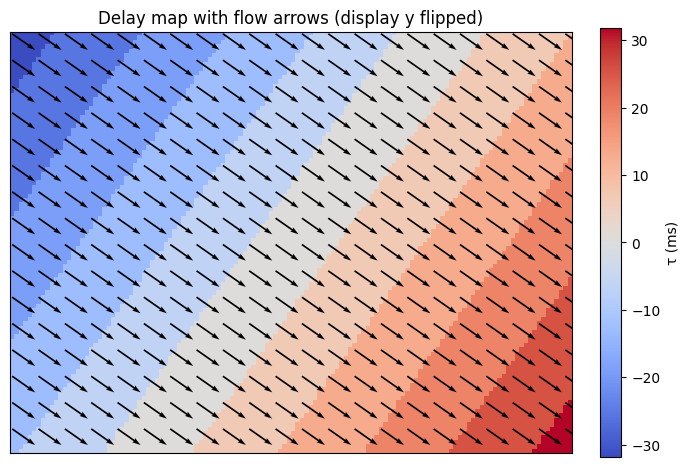

In [ ]:
# ---------- Step 3: Plane fit to τ(X,Y) and velocity extraction ----------
def fit_tau_plane_and_velocity(
    tau_map,                   # (ny, nx) seconds; NaN where invalid
    px_size_mm: float,         # pixel size (mm/px)
    Xmax=None,                 # optional (ny, nx) similarity weights
    weight_power: float = 1.0  # raise Xmax to this power for weighting
):
    """
    Fit τ(X,Y) = A*X + B*Y + C (X,Y in mm), then compute:
        grad_tau = (A, B) [s/mm]
        speed_mm_s = 1 / ||grad_tau||
        unit_dir   = grad_tau / ||grad_tau||
        v_vec_mm_s = unit_dir * speed_mm_s = grad_tau / ||grad_tau||^2

    Returns
    -------
    results : dict with keys:
        A_s_per_mm, B_s_per_mm, C_s
        grad_tau_s_per_mm : (2,)
        speed_mm_s : float
        unit_dir : (2,)
        v_vec_mm_s : (2,)
    """
    ny, nx = tau_map.shape

    # Build coordinate grid in *mm*
    y_px = np.arange(ny)
    x_px = np.arange(nx)
    Y_px, X_px = np.meshgrid(y_px, x_px, indexing="ij")
    X_mm = X_px * px_size_mm
    Y_mm = Y_px * px_size_mm

    # Valid points
    valid = np.isfinite(tau_map)
    if valid.sum() < 3:
        raise ValueError("Not enough valid τ points to fit a plane.")

    X_col = X_mm[valid].ravel()
    Y_col = Y_mm[valid].ravel()
    T_col = tau_map[valid].ravel()

    # Optional weights from similarity (emphasize more reliable pixels)
    if Xmax is not None:
        W = np.clip(Xmax[valid].ravel(), 0, 1) ** weight_power
    else:
        W = np.ones_like(T_col)

    # Design matrix for τ = A X + B Y + C
    M = np.column_stack([X_col, Y_col, np.ones_like(X_col)])

    # Weighted least squares via normal equations on sqrt-weights
    # (equivalently np.linalg.lstsq(M*w[:,None], T*w))
    w = np.sqrt(W)
    Mw = M * w[:, None]
    Tw = T_col * w
    coeffs, *_ = np.linalg.lstsq(Mw, Tw, rcond=None)
    A, B, C = coeffs  # [s/mm], [s/mm], [s]

    grad_tau = np.array([A, B])                  # s/mm
    grad_norm = np.linalg.norm(grad_tau)         # s/mm
    speed = 1.0 / grad_norm                      # mm/s
    unit_dir = grad_tau / (grad_norm + 1e-15)    # unit vector (same direction as propagation)
    v_vec = grad_tau / (grad_norm**2 + 1e-15)    # mm/s vector (same direction as grad_tau)

    return dict(
        A_s_per_mm=A,
        B_s_per_mm=B,
        C_s=C,
        grad_tau_s_per_mm=grad_tau,
        speed_mm_s=speed,
        unit_dir=unit_dir,
        v_vec_mm_s=v_vec
    )

# ---- Run the fit on your τ map from Step 2 ----
res = fit_tau_plane_and_velocity(
    tau_map,
    px_size_mm=meta["px_size_mm"],
    Xmax=Xmax,
    weight_power=2.0  # mild emphasis on high-similarity pixels
)

print(f"A = {res['A_s_per_mm']:.6f} s/mm,  B = {res['B_s_per_mm']:.6f} s/mm")
print(f"|∇τ| = {np.linalg.norm(res['grad_tau_s_per_mm']):.6f} s/mm")
print(f"Estimated speed = {res['speed_mm_s']:.2f} mm/s")
theta_est_deg = np.degrees(np.arctan2(res['unit_dir'][1], res['unit_dir'][0]))
print(f"Estimated direction (deg from +x) = {theta_est_deg:.2f}°")
print(f"Estimated velocity vector v = [{res['v_vec_mm_s'][0]:.2f}, {res['v_vec_mm_s'][1]:.2f}] mm/s")

# ---- Compare to ground truth from Step 1 meta ----
true_speed = meta["speed_mm_s"]
true_theta = meta["direction_deg"]
ux, uy = meta["ux"], meta["uy"]
true_vec = np.array([true_speed*ux, true_speed*uy])

print("\nGround truth:")
print(f"Speed = {true_speed:.2f} mm/s")
print(f"Direction = {true_theta:.2f}°")
print(f"Velocity vector v_true = [{true_vec[0]:.2f}, {true_vec[1]:.2f}] mm/s")

# Convert velocity vector to pixel units for plotting arrows
# (since imshow pixel aspect ratio is 1:1)
px_size_mm = meta["px_size_mm"]
v_vec_px = res['v_vec_mm_s'] / px_size_mm  # mm/s ÷ (mm/px) = px/s
unit_dir_px = v_vec_px / np.linalg.norm(v_vec_px)

step = 6
ny, nx = tau_map.shape
Y_grid, X_grid = np.mgrid[0:ny:step, 0:nx:step]

U = np.full_like(X_grid, unit_dir_px[0], dtype=float)
V = np.full_like(Y_grid, unit_dir_px[1], dtype=float)

fig, ax = plt.subplots(figsize=(6.8,4.6), constrained_layout=True)
im = ax.imshow(1e3*tau_map, cmap="coolwarm", origin="upper")
plt.colorbar(im, ax=ax, fraction=0.046, label="τ (ms)")

px = meta["px_size_mm"]
v_px = res['v_vec_mm_s'] / px
u_px = v_px / np.linalg.norm(v_px)

step = 6
ny, nx = tau_map.shape
Yg, Xg = np.mgrid[0:ny:step, 0:nx:step]
ax.quiver(Xg, Yg, u_px[0]*np.ones_like(Xg), -u_px[1]*np.ones_like(Yg),  # note minus
          scale=20, color="k", width=0.003)

ax.set_title("Delay map with flow arrows")
ax.set_xticks([]); ax.set_yticks([])
plt.show()